In [1]:
# Set path to constraints directory
from shared_utils import setup_paths

notebook_dir, constraints_dir, PATH = setup_paths()

In [2]:
# Import shared libraries
from shared_utils import (
    RandomForestClassifier, load_iris, train_test_split,
    np, pd, plt, sns, ast,
    euclidean, cityblock, cosine, cdist
)

In [3]:
# Load the Iris dataset and train model
from shared_utils import load_and_train_model

iris, X, y, X_train, X_test, y_train, y_test, model = load_and_train_model()

In [4]:
X_test[0]

array([6.1, 2.8, 4.7, 1.2])

In [5]:
# Using classical constraints
from shared_utils import load_constraints_source

constraints_source = load_constraints_source(PATH)

In [6]:
# Constraint parsing functions
from shared_utils import (
    parse_condition, constraints_v1_to_dict, transform_by_feature,
    get_intervals_by_feature, is_value_valid_for_class
)

# Example usage
constraints = constraints_v1_to_dict(constraints_source)
validity = is_value_valid_for_class("Class 1", "petal width (cm)", 0.5, constraints)
validity

True

In [7]:
# Read constraints from file
from shared_utils import read_constraints_from_file

constraints = read_constraints_from_file(PATH + "custom_l100_pv0.001_t2_dpg_metrics.txt")
print(constraints)

{'Class 0': [{'feature': 'petal_length', 'min': None, 'max': 5.05}, {'feature': 'petal_width', 'min': None, 'max': 1.75}, {'feature': 'sepal_length', 'min': 5.15, 'max': 6.15}, {'feature': 'sepal_width', 'min': 2.8, 'max': 3.25}], 'Class 1': [{'feature': 'petal_length', 'min': 2.15, 'max': 5.45}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 7.1}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.7}], 'Class 2': [{'feature': 'petal_length', 'min': 2.35, 'max': 5.25}, {'feature': 'petal_width', 'min': 0.6, 'max': 1.9}, {'feature': 'sepal_length', 'min': 4.95, 'max': 6.75}, {'feature': 'sepal_width', 'min': 2.25, 'max': 3.25}]}


In [8]:
# PCA plotting functions
from shared_utils import plot_pca_with_counterfactual, plot_pca_with_counterfactuals

In [9]:
# Pairwise plotting functions
from shared_utils import plot_pairwise_with_counterfactual, plot_pairwise_with_counterfactual_df

# Example usage
# Assuming you have a trained model, a dataset (as a DataFrame or array), target labels, and samples
# plot_pairwise_with_counterfactual(model, X, y, sample, counterfactual)

/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/rafael/gitgud/CounterFactualDPG/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


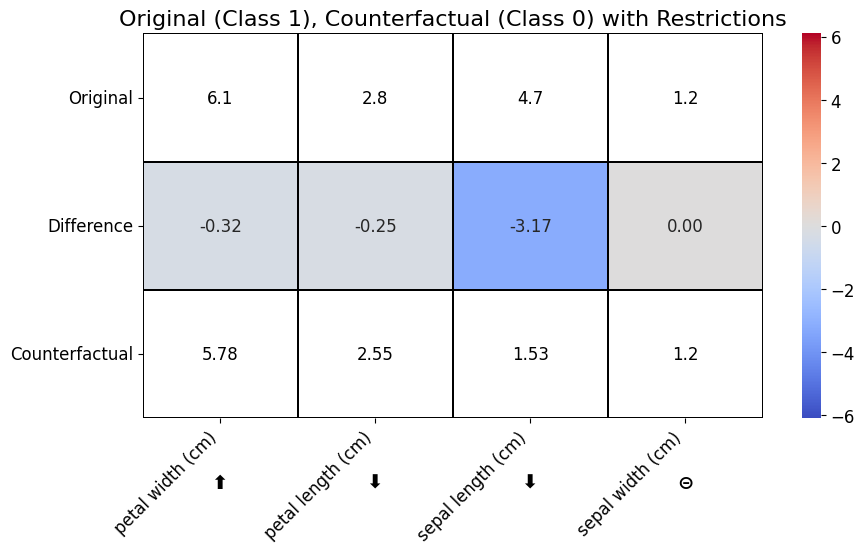

In [10]:
# Heatmap plotting function
from shared_utils import plot_sample_and_counterfactual_heatmap

# Example usage
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
counterfactual = {'petal width (cm)': 5.78, 'petal length (cm)': 2.55, 'sepal length (cm)': 1.53, 'sepal width (cm)': 1.2}
class_sample = model.predict(pd.DataFrame([sample]))[0]
class_counterfactual = model.predict(pd.DataFrame([counterfactual]))[0]
restrictions = {'petal width (cm)': 'non_decreasing', 'petal length (cm)': 'non_increasing', 'sepal length (cm)': 'non_increasing', 'sepal width (cm)': 'no_change'}
plot_sample_and_counterfactual_heatmap(sample, class_sample,  counterfactual, class_counterfactual, restrictions)

Original: {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
Generated Counterfactual: {'petal width (cm)': np.float64(6.1), 'petal length (cm)': np.float64(2.8), 'sepal length (cm)': np.float64(4.99), 'sepal width (cm)': np.float64(0.69)}
Predicted Class for Original Sample: [1]
Prediction Class CounterFactual [0]


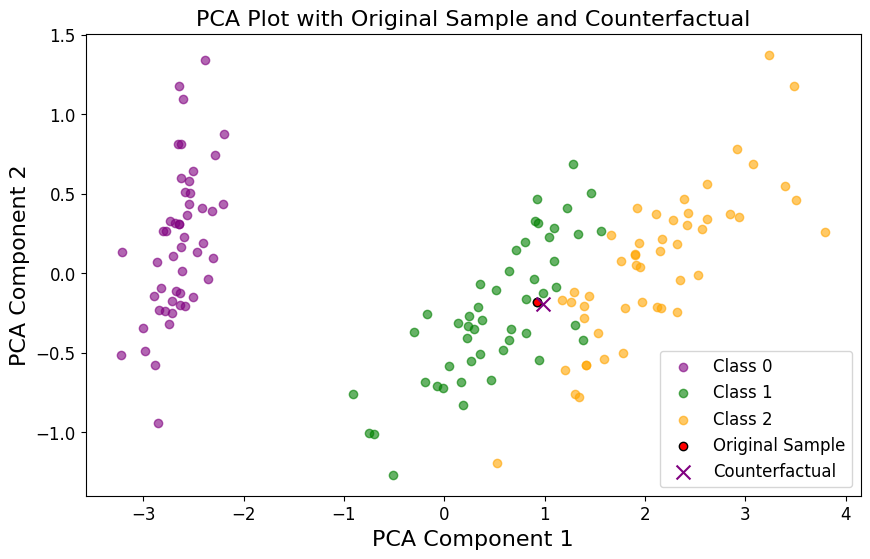

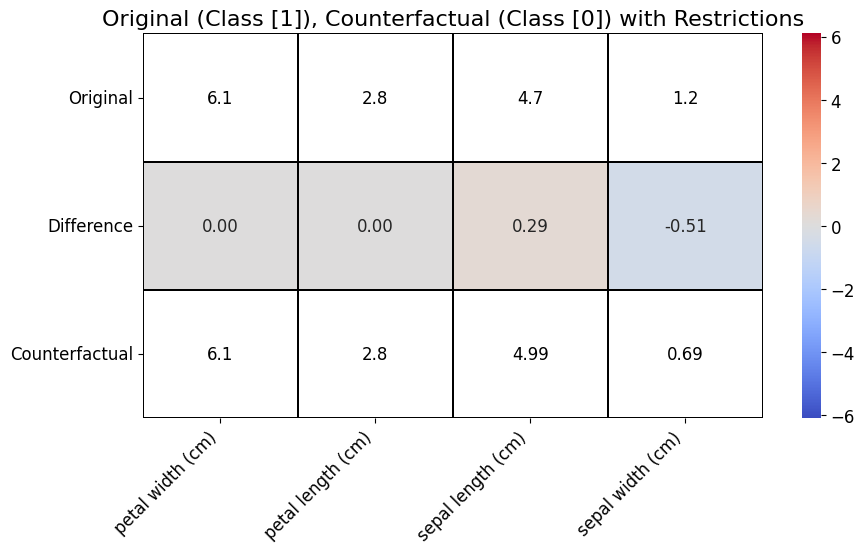

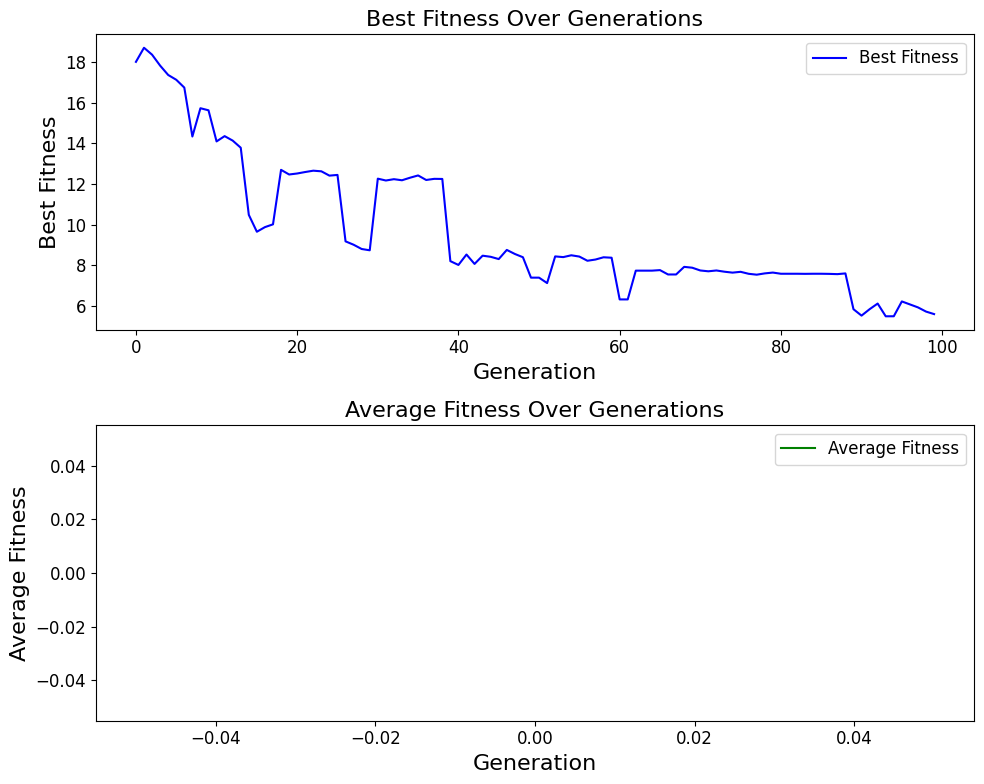

In [11]:
from shared_utils import CounterFactualDPG

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Original sample
#sample = {'petal width (cm)': 1.0, 'petal length (cm)': 2.0, 'sepal length (cm)': 1.0, 'sepal width (cm)': 3.5}
sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}

# Create a DataFrame from the sample
sample_df = pd.DataFrame([sample])  # Wrapping sample in a list to create a DataFrame

# Initialize the CounterFactualDPG class with the model and constraints
cf_dpg = CounterFactualDPG(model, constraints)  # Ensure you are using the correct constraints (nested_dict)
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'no_change'}
#dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
#dict_non_actionable = {'petal width (cm)': 'no_change', 'sepal length (cm)': 'non_decreasing'}
dict_non_actionable = {}

cf_dpg.dict_non_actionable = dict_non_actionable

# Generate a counterfactual for the target class
counterfactual = cf_dpg.generate_counterfactual(sample, target_class=0)
print("Original:", sample)
print("Generated Counterfactual:", counterfactual)

# Predict the class for the original sample using the model
predicted_class = model.predict(sample_df)
print("Predicted Class for Original Sample:", predicted_class)
print('Prediction Class CounterFactual', model.predict(pd.DataFrame([counterfactual])))

plot_pca_with_counterfactual(model, X, y, sample, counterfactual)
plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
cf_dpg.plot_fitness()

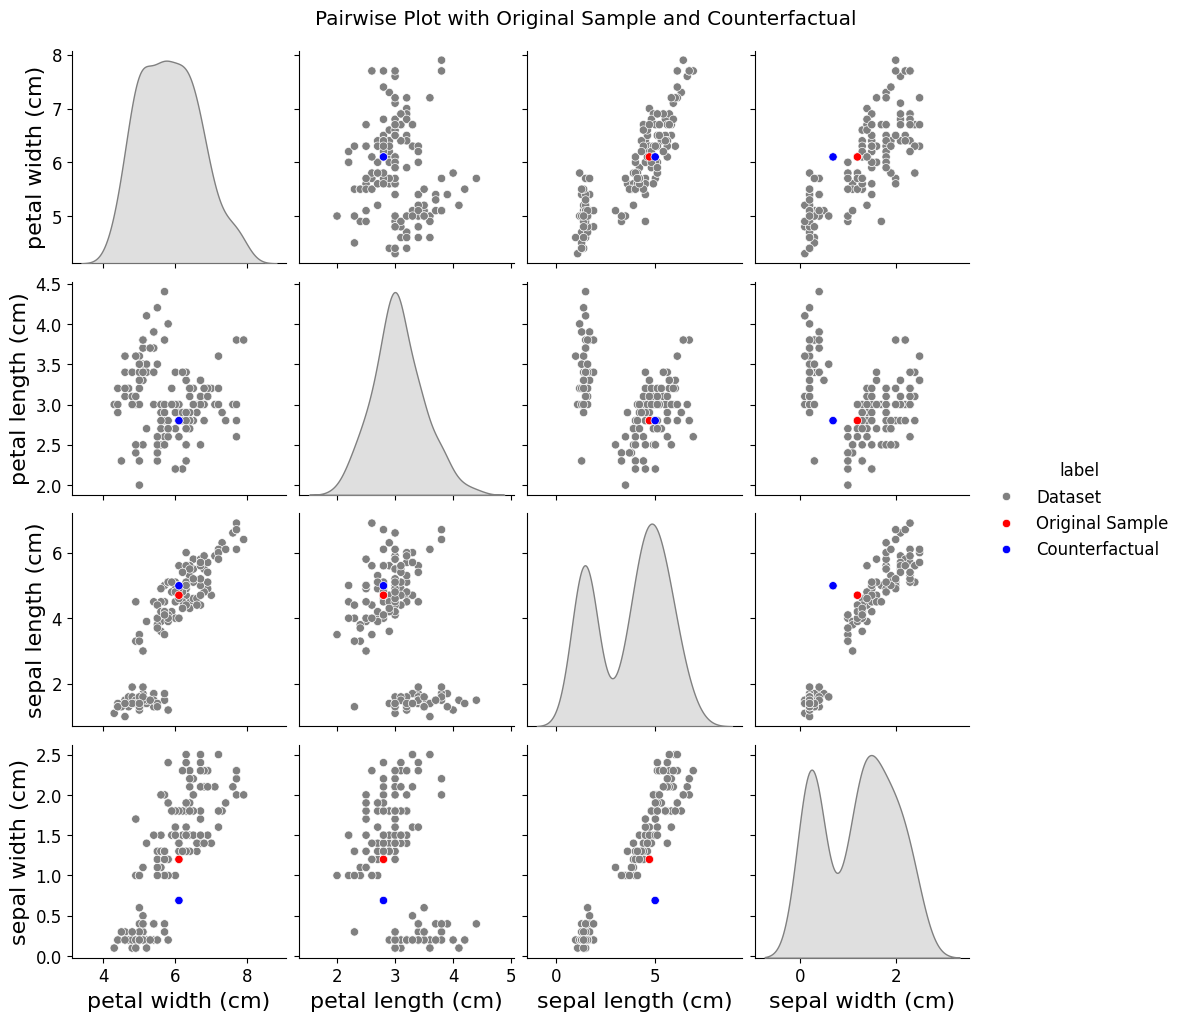

In [12]:
plot_pairwise_with_counterfactual(model, X, y, sample, counterfactual)

Convergence reached at generation 21


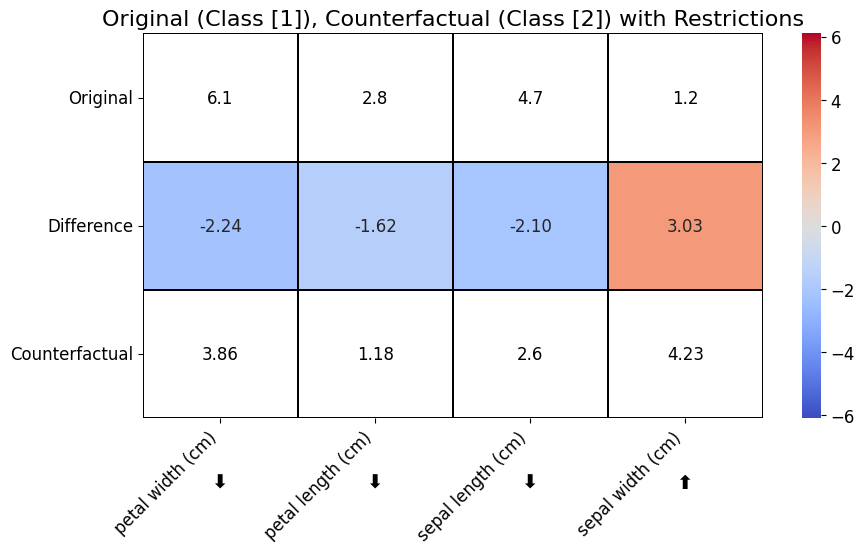

Convergence reached at generation 21


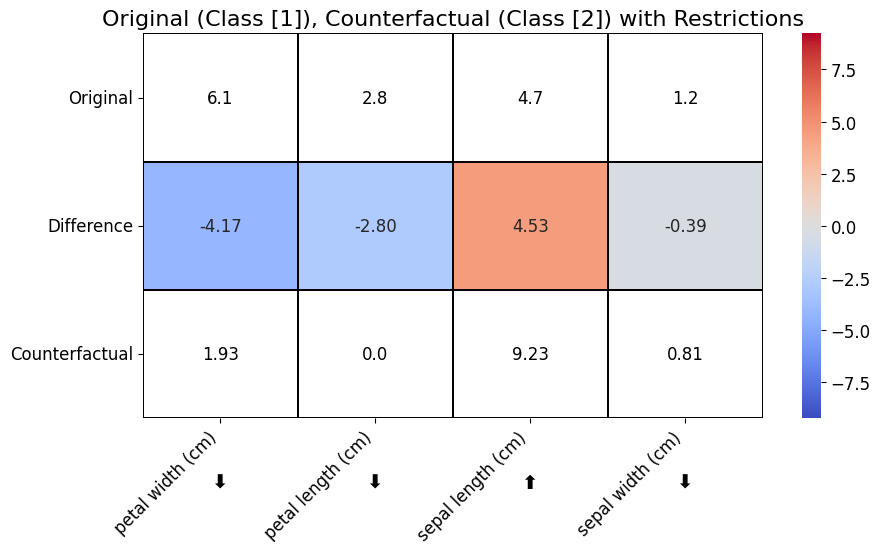

Convergence reached at generation 21


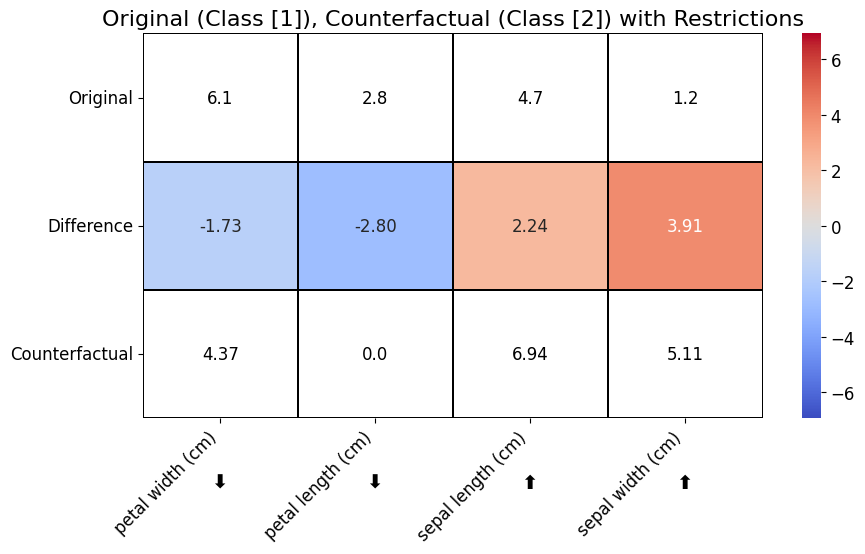

Convergence reached at generation 21


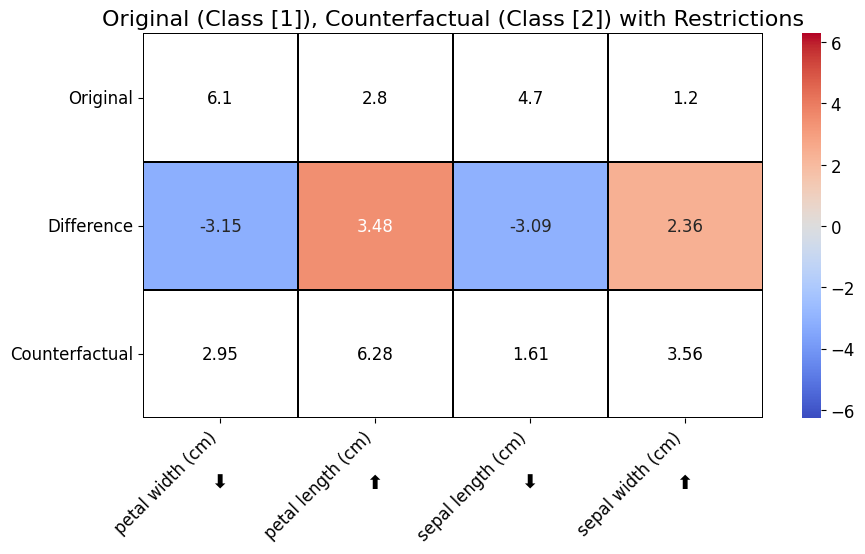

Convergence reached at generation 21


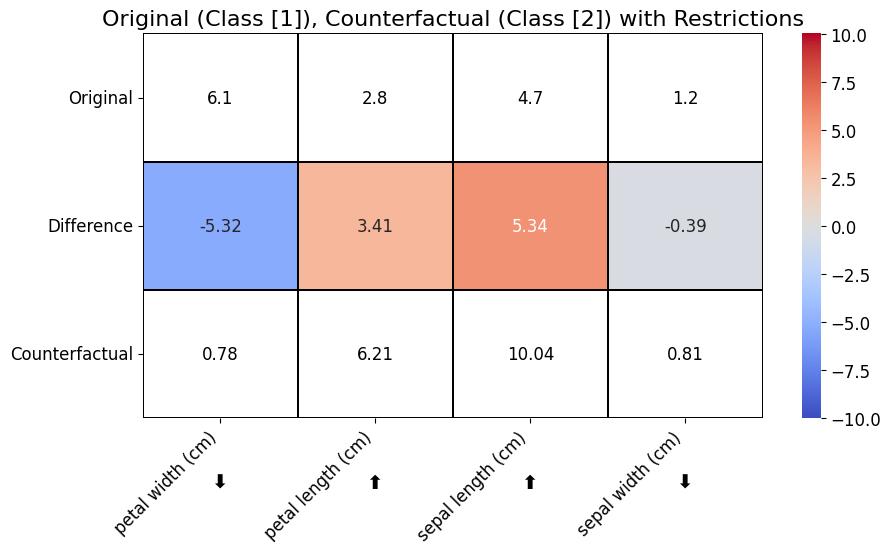

Convergence reached at generation 21


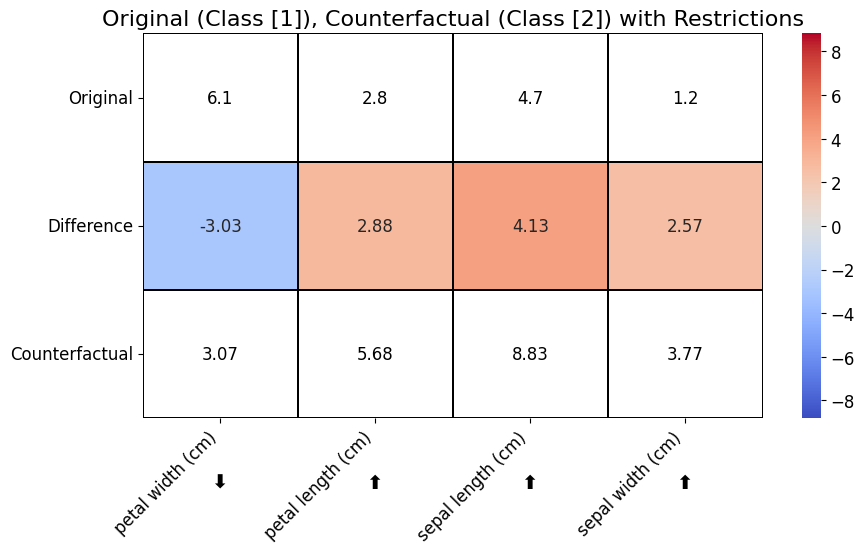

Convergence reached at generation 21


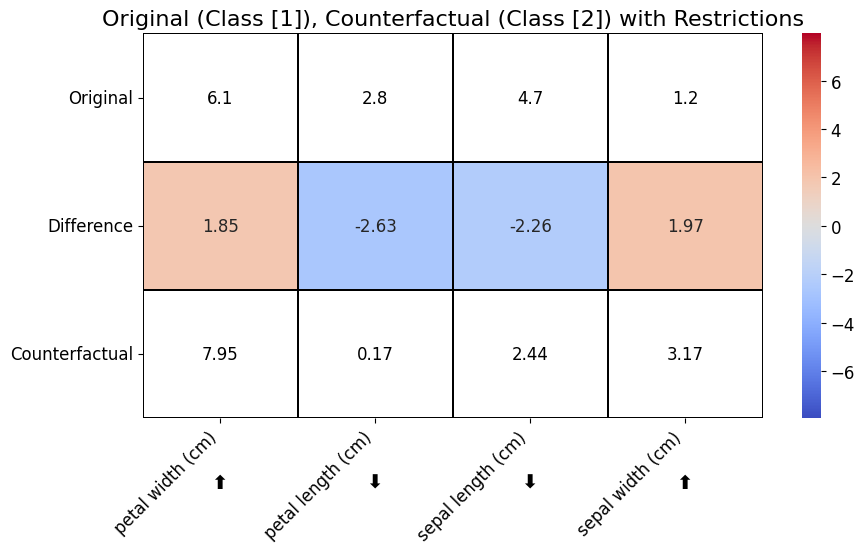

Convergence reached at generation 21


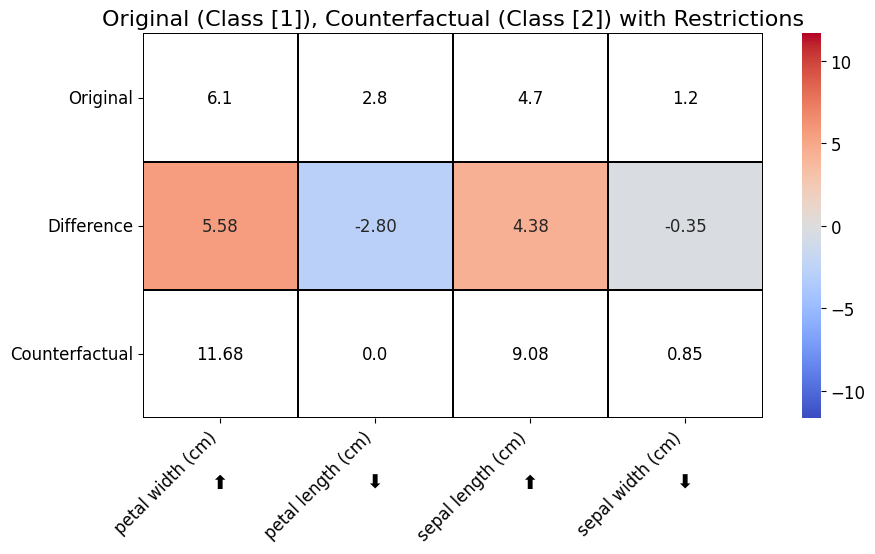

Convergence reached at generation 21


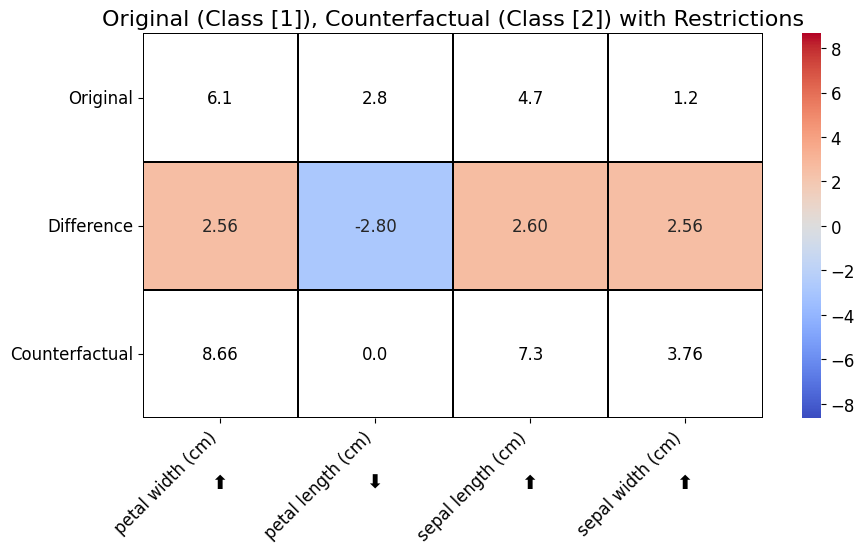

Convergence reached at generation 21


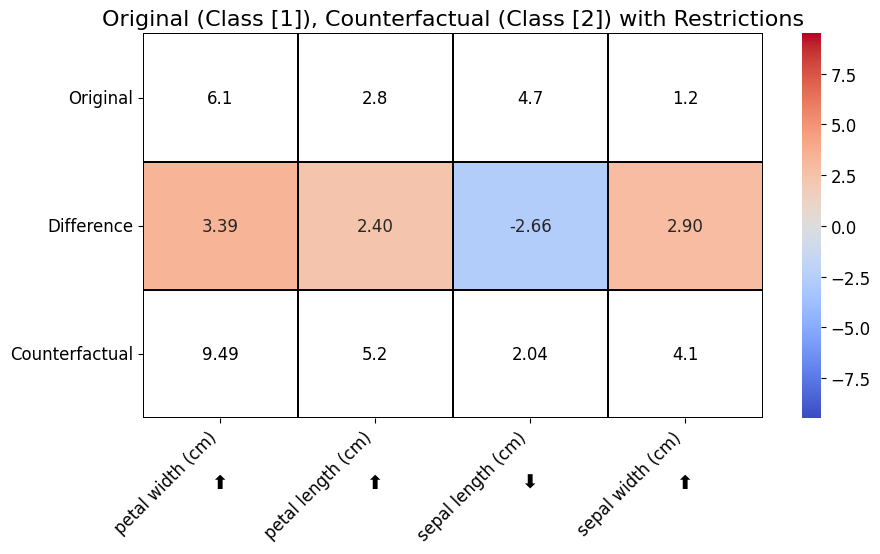

Convergence reached at generation 21


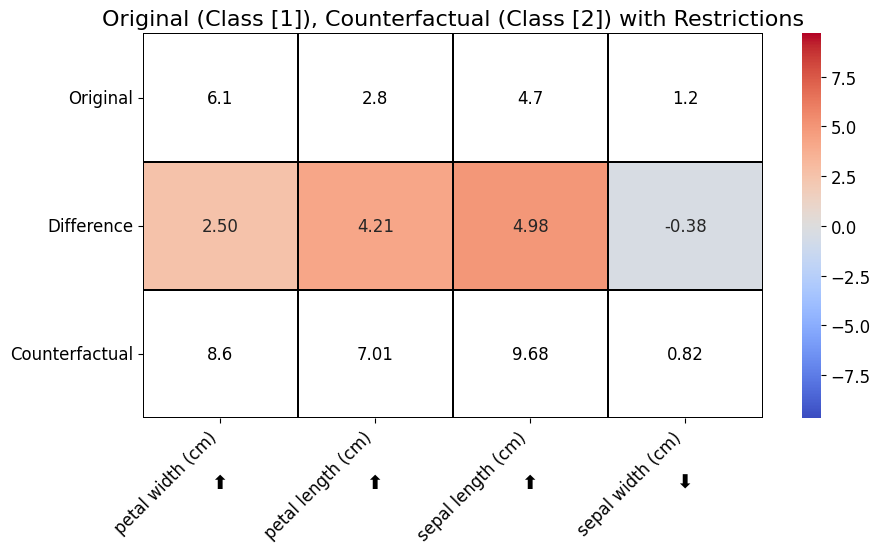

Convergence reached at generation 21


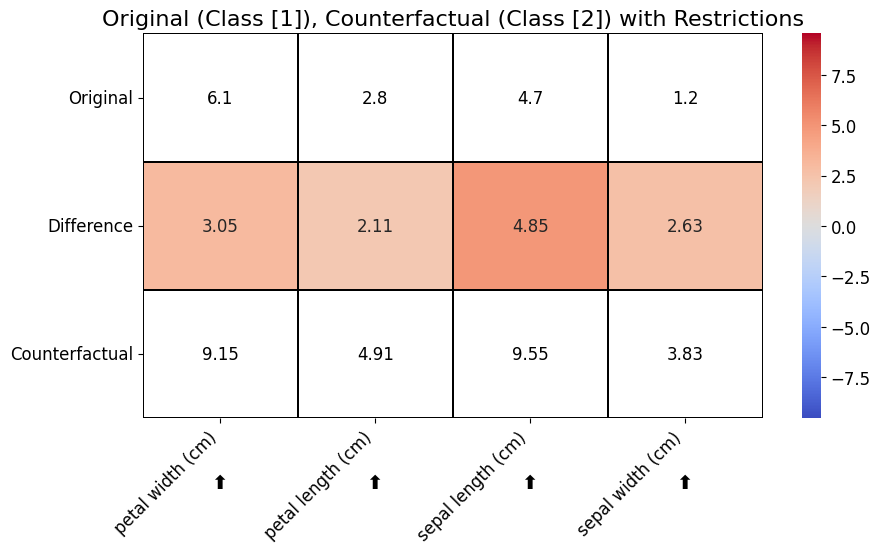

    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               3.86               1.18               2.60              4.23   
1               1.93               0.00               9.23              0.81   
2               4.37               0.00               6.94              5.11   
3               2.95               6.28               1.61              3.56   
4               0.78               6.21              10.04              0.81   
5               3.07               5.68               8.83              3.77   
6               7.95               0.17               2.44              3.17   
7              11.68               0.00               9.08              0.85   
8               8.66               0.00               7.30              3.76   
9               9.49               5.20               2.04              4.10   
10              8.60               7.01               9.68              0.82   
11              9.15               4.91 

In [13]:
import itertools

sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
#rules = ['no_change', 'non_increasing', 'non_decreasing']
rules = ['non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df = []

# Iterate through each combination of rules
for combination in rule_combinations:
    dict_non_actionable = dict(zip(feature_names, combination))

    # Create an instance of the CounterFactualDPG class
    cf_dpg = CounterFactualDPG(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)
# Displaying the DataFrame
print(counterfactuals_df)

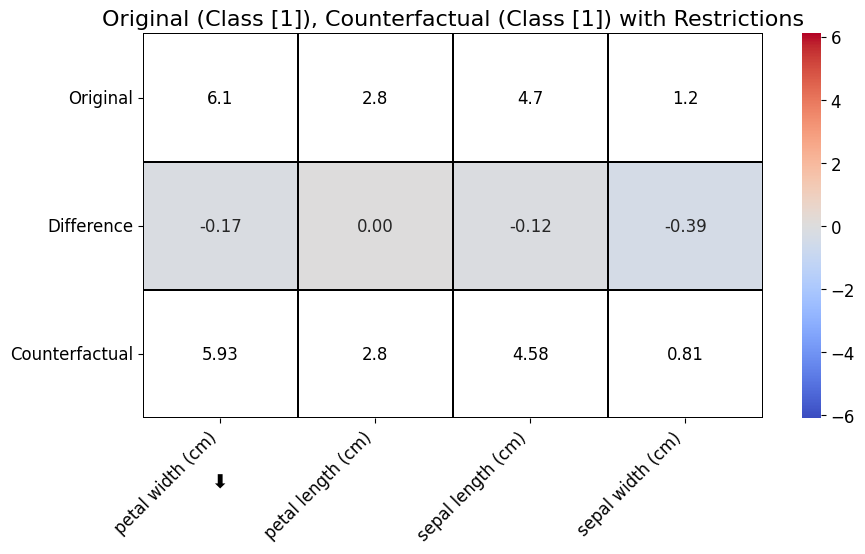

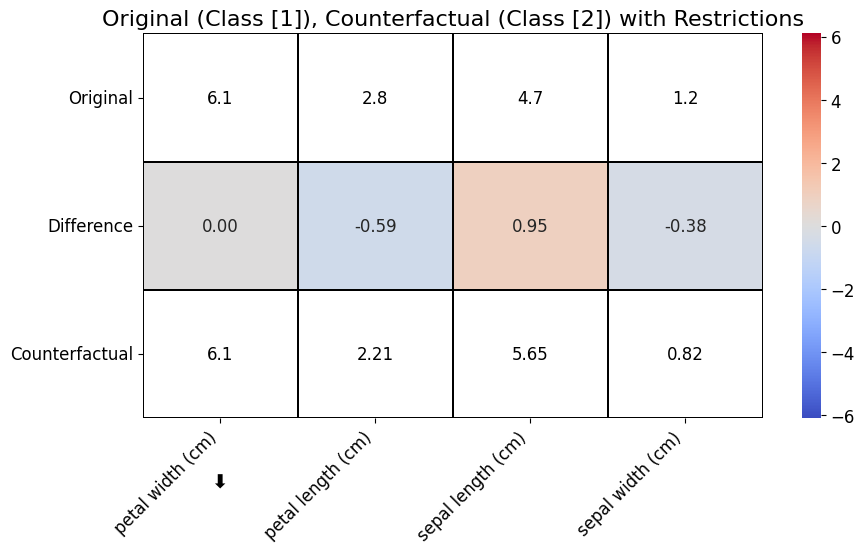

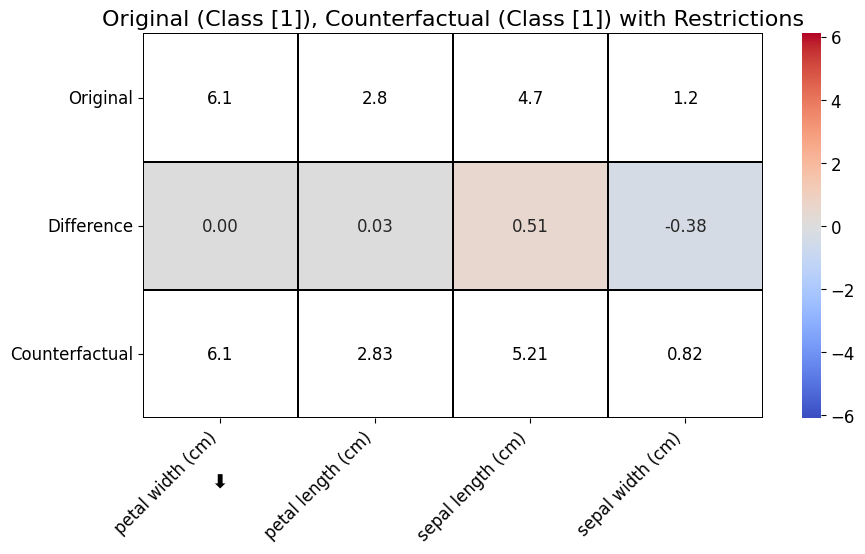

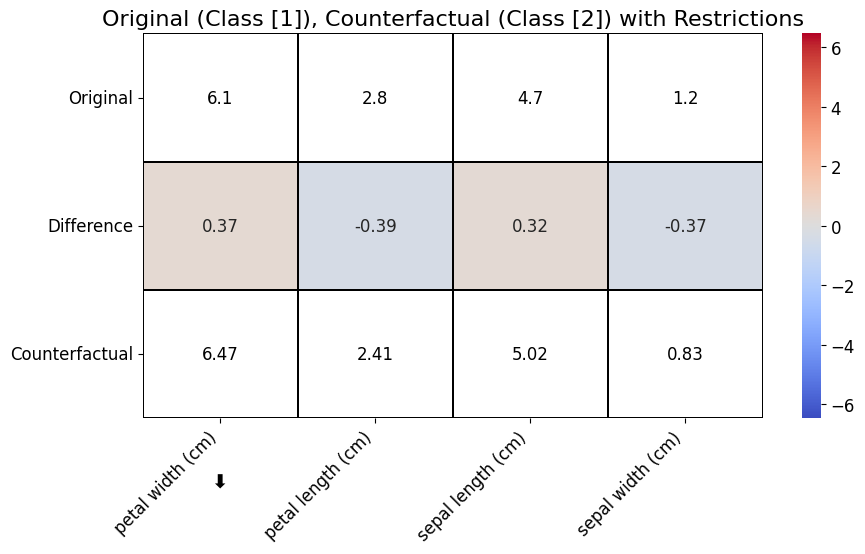

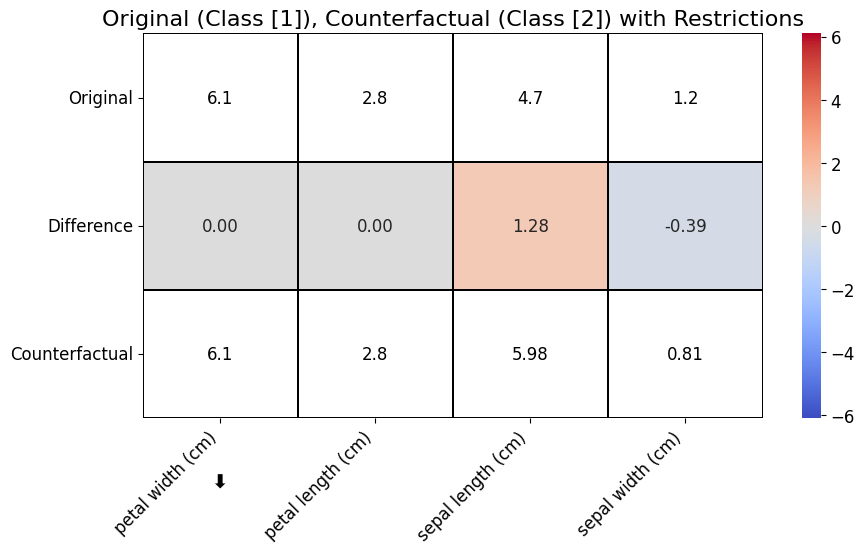

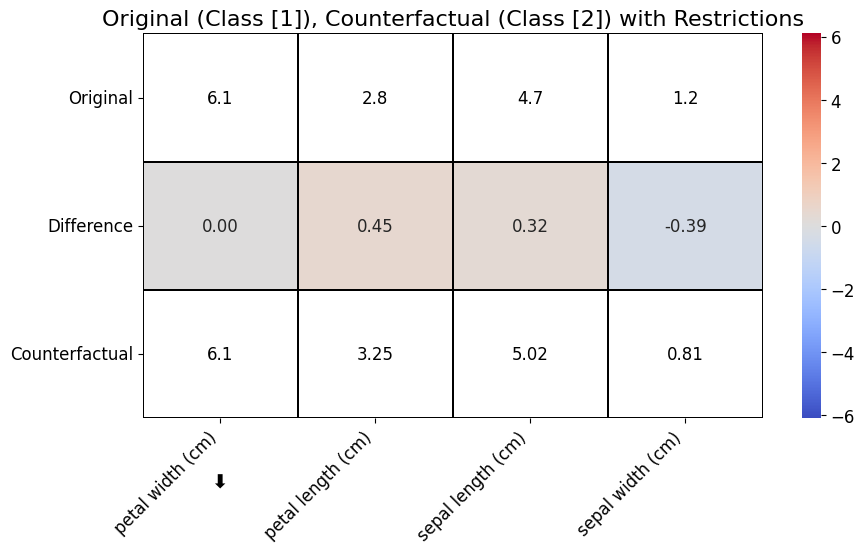

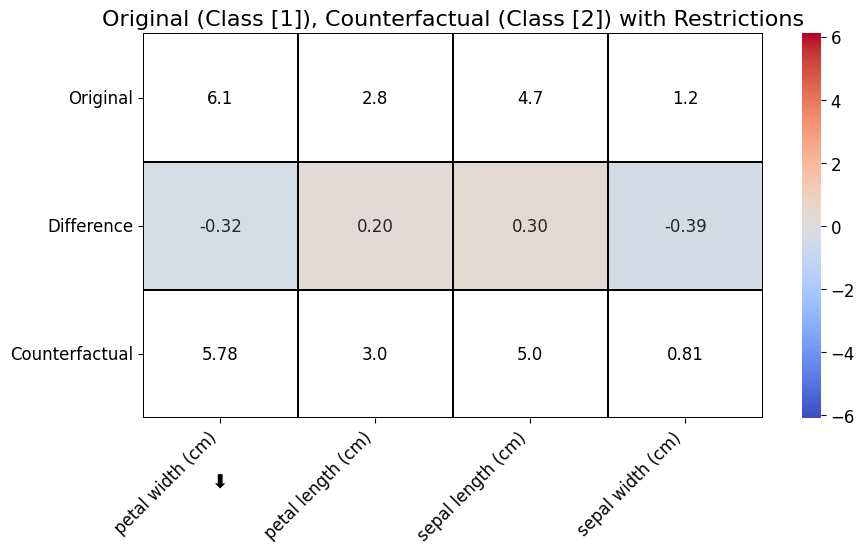

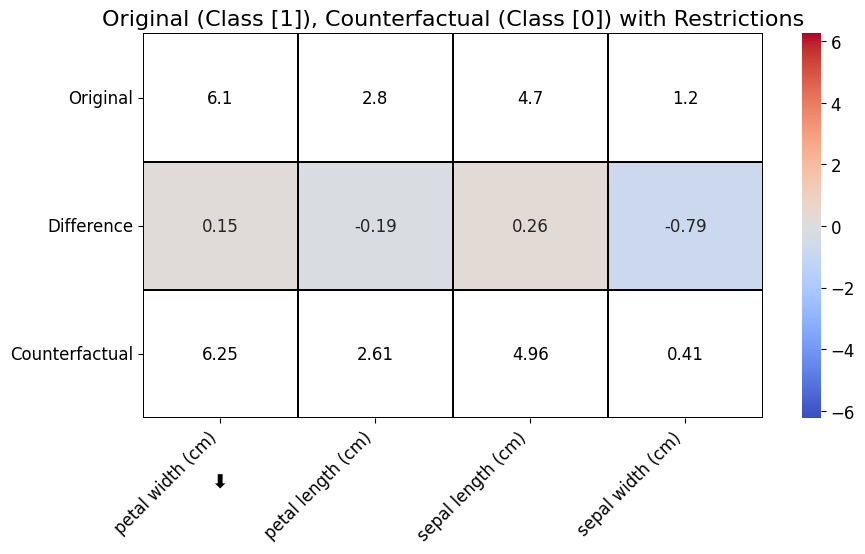

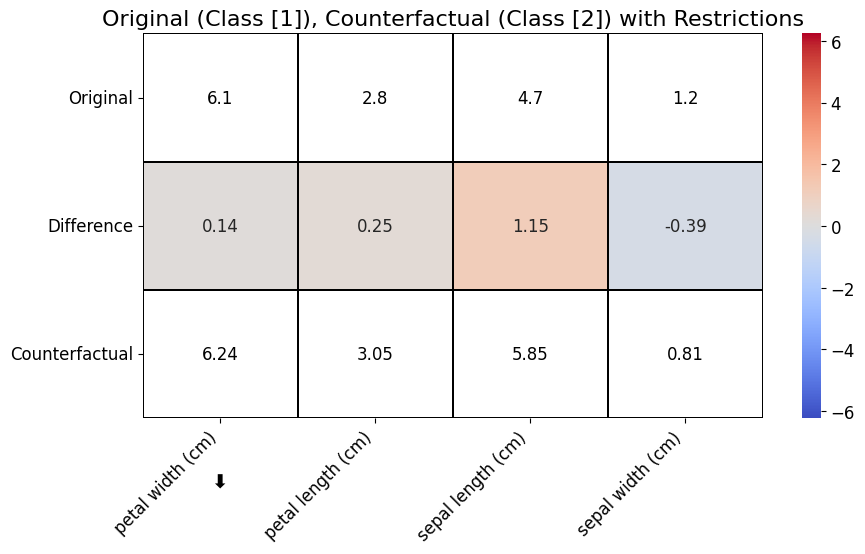

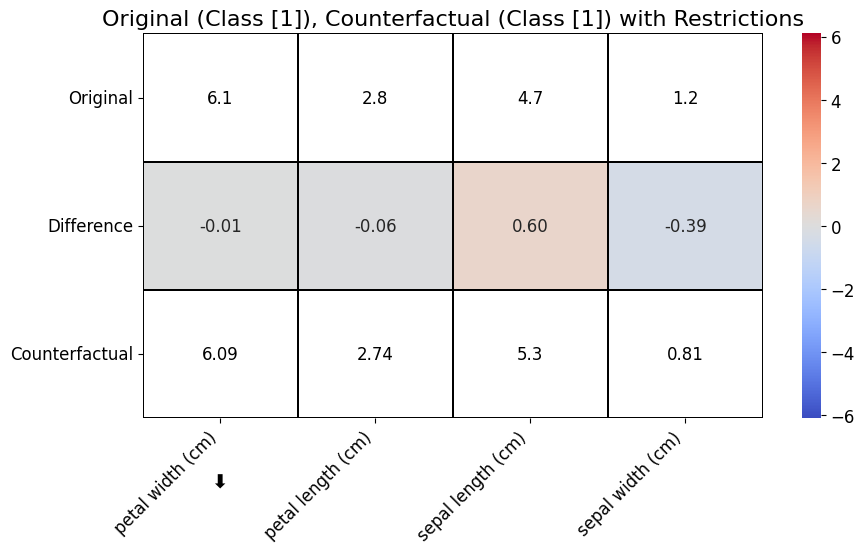

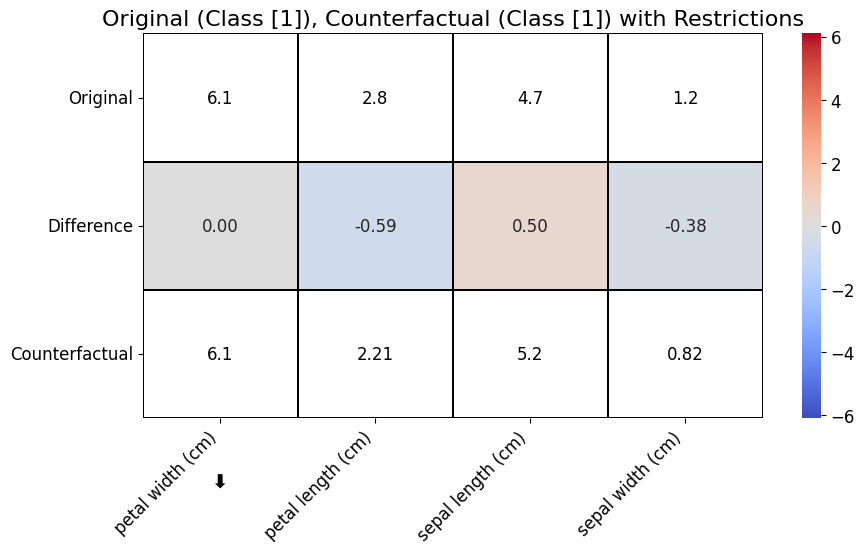

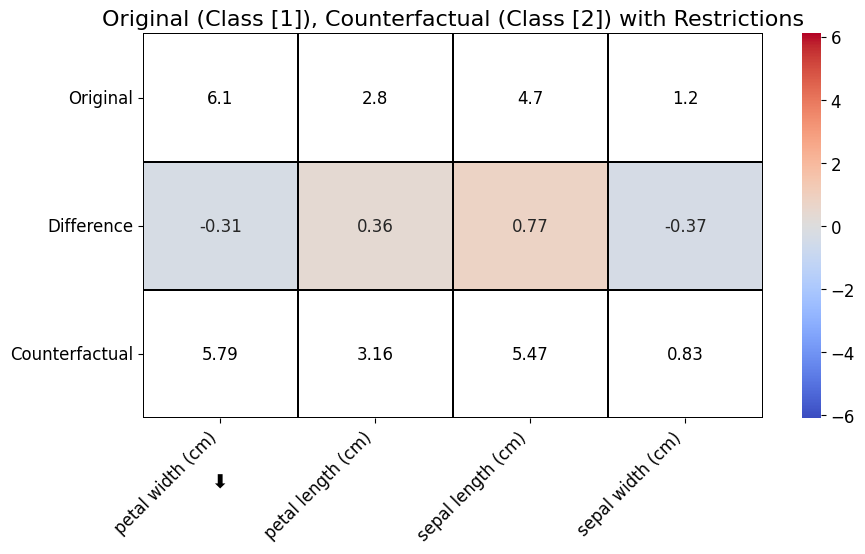

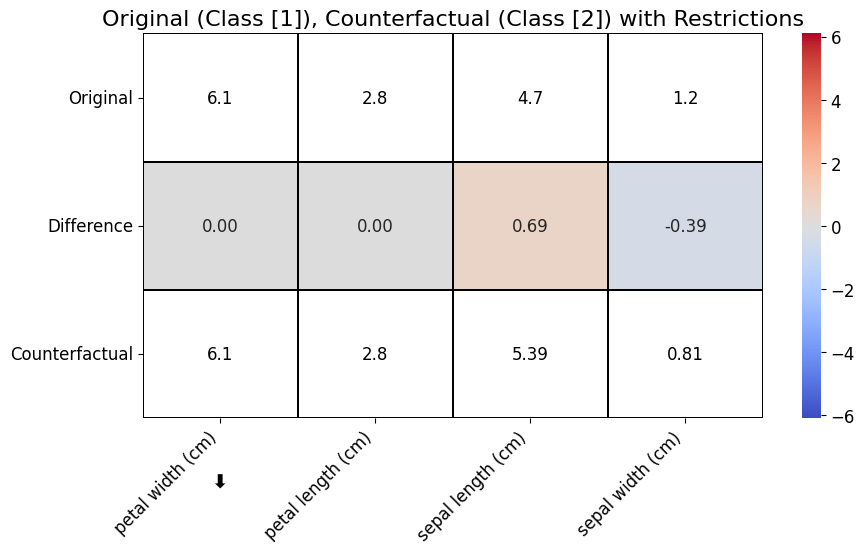

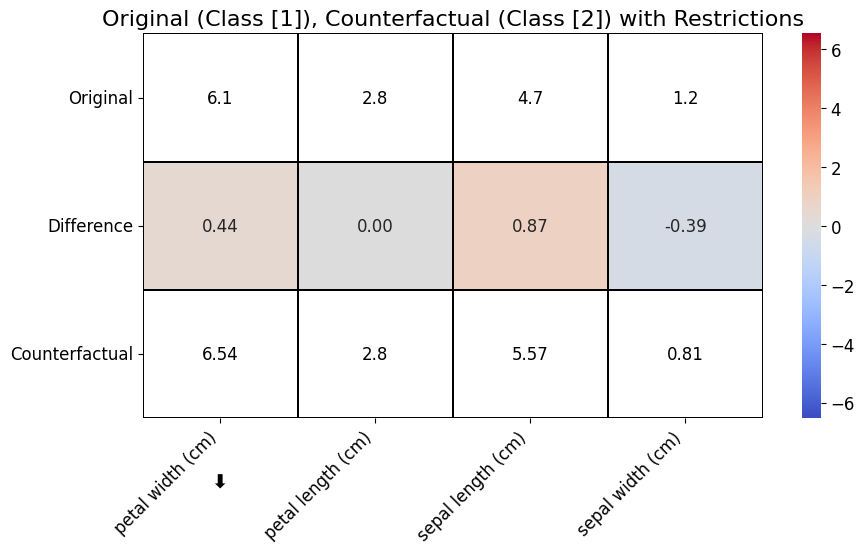

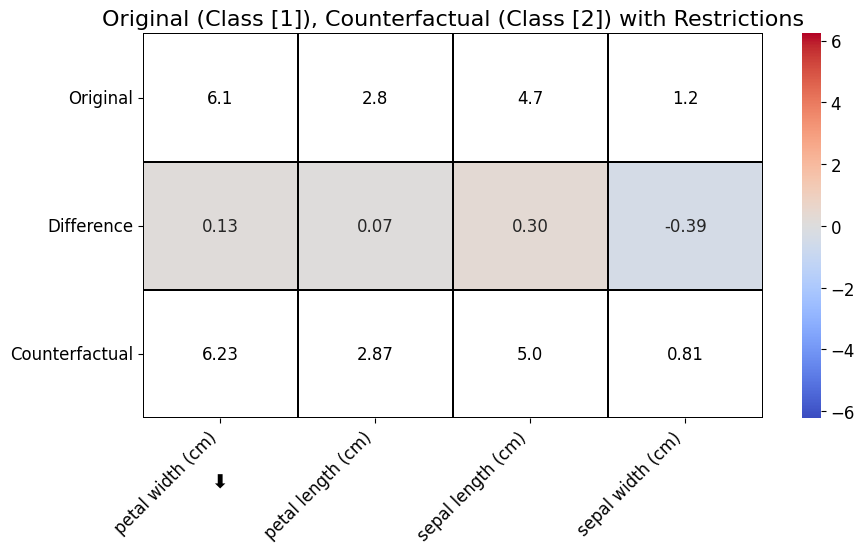

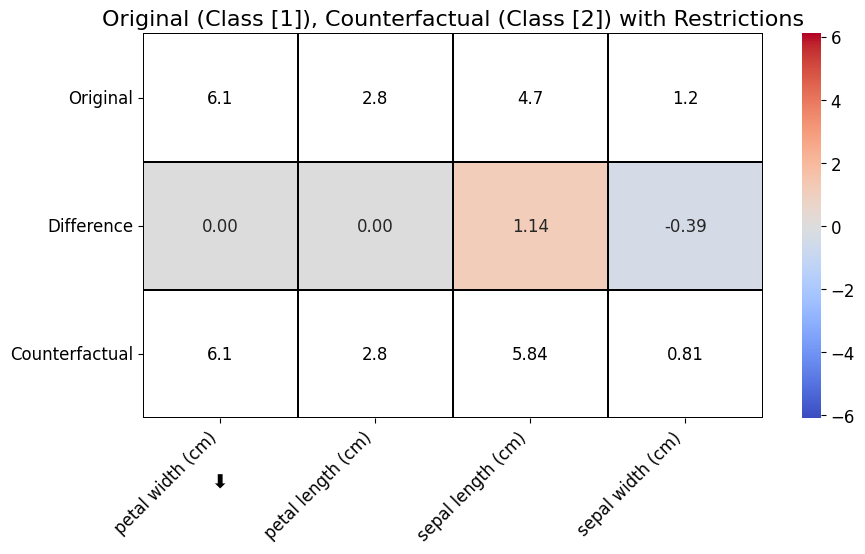

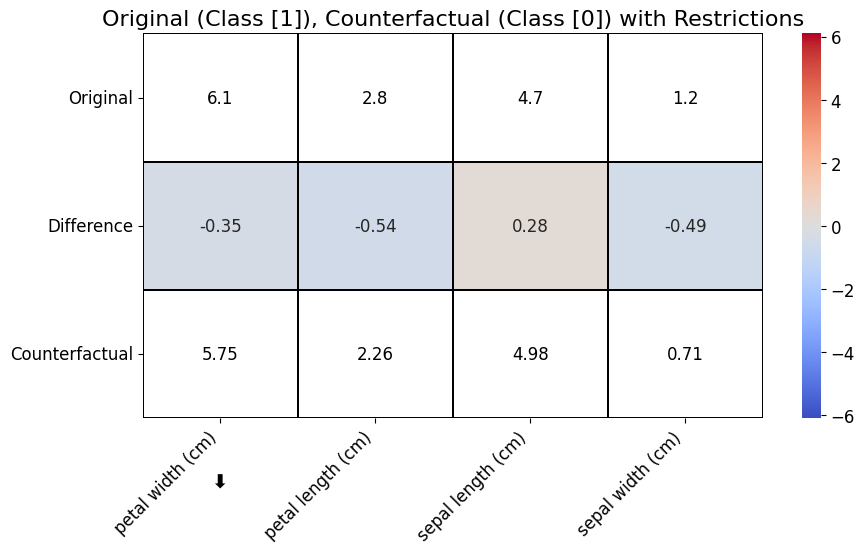

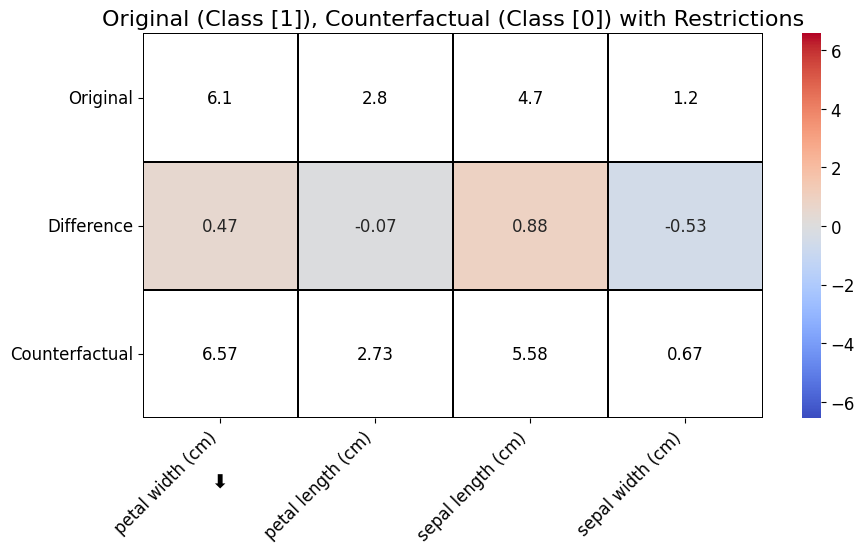

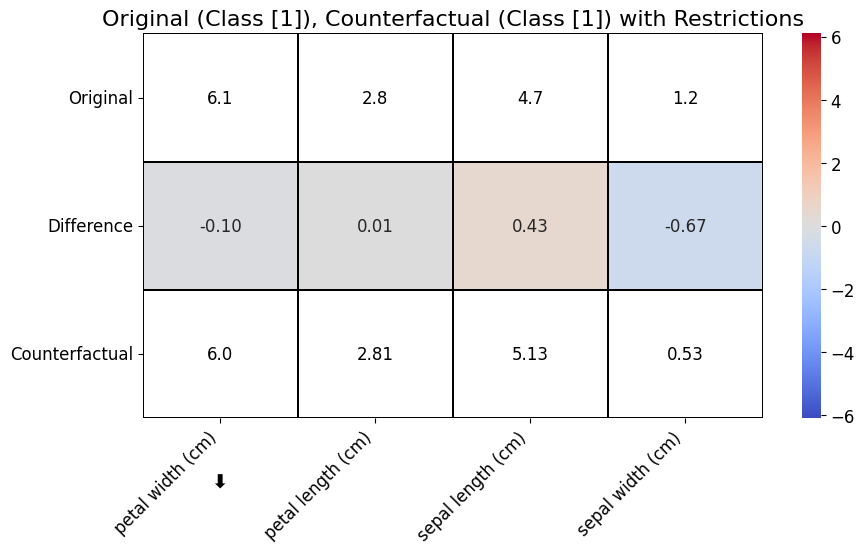

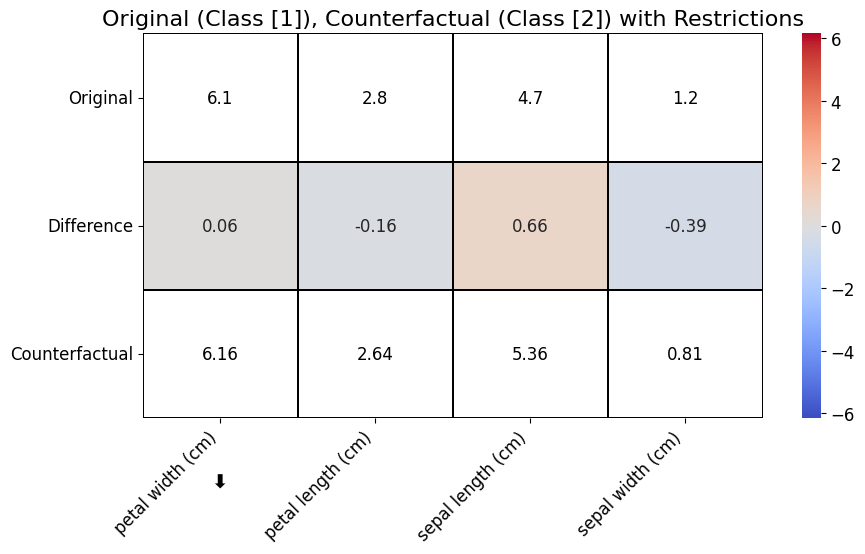

    petal width (cm)  petal length (cm)  sepal length (cm)  sepal width (cm)  \
0               5.93               2.80               4.58              0.81   
1               6.10               2.21               5.65              0.82   
2               6.10               2.83               5.21              0.82   
3               6.47               2.41               5.02              0.83   
4               6.10               2.80               5.98              0.81   
5               6.10               3.25               5.02              0.81   
6               5.78               3.00               5.00              0.81   
7               6.25               2.61               4.96              0.41   
8               6.24               3.05               5.85              0.81   
9               6.09               2.74               5.30              0.81   
10              6.10               2.21               5.20              0.82   
11              5.79               3.16 

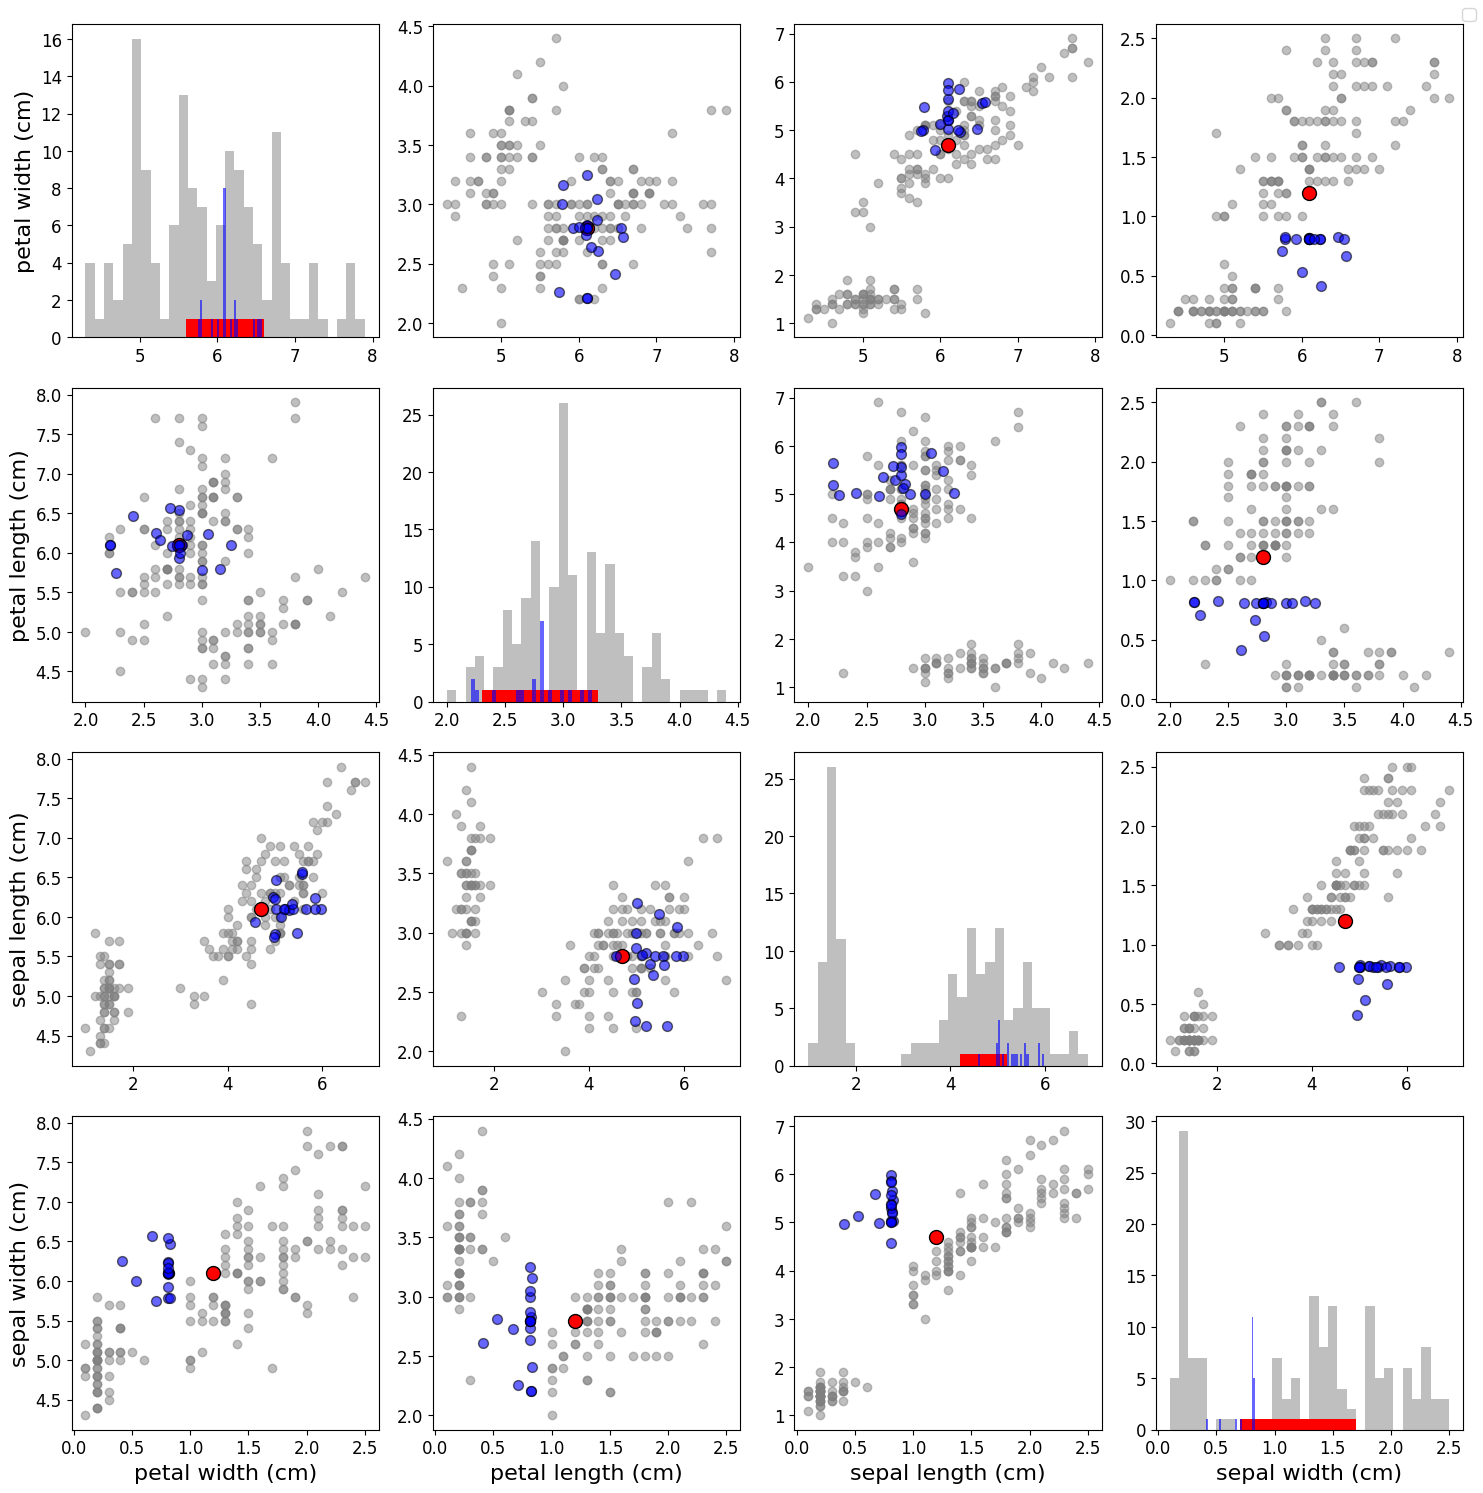

In [14]:
import itertools

sample = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
rules = ['no_change', 'non_increasing', 'non_decreasing']

# Generate all possible combinations of rules for each feature
feature_names = list(sample.keys())
rule_combinations = list(itertools.product(rules, repeat=len(feature_names)))

counterfactuals_df = []

for replicatons in range(20):
  # Iterate through each combination of rules
    #dict_non_actionable = {'sepal width (cm)': 'no_change', 'sepal length (cm)': 'non_increasing'}
    dict_non_actionable = {'sepal width (cm)': 'non_increasing'}

    # Create an instance of the CounterFactualDPG class
    cf_dpg = CounterFactualDPG(model, constraints)
    cf_dpg.dict_non_actionable = dict_non_actionable

    # Generate counterfactual
    counterfactual = cf_dpg.generate_counterfactual(sample, target_class=2)
    if (counterfactual == None):
        continue

    plot_sample_and_counterfactual_heatmap(sample, predicted_class, counterfactual,  model.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})

    # Append to DataFrame
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)
# Displaying the DataFrame
print(counterfactuals_df)

plot_pairwise_with_counterfactual_df(model, X, y, sample, counterfactuals_df)